In [90]:
import sys
import os
sys.path.append("../")
import time

from src.datasets.SNLIData import SNLIData
from src.datasets.BankData import BankData

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import recall_score, make_scorer

import torch
from torch import nn

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from src.models.NeuralNetwork import NeuralNetworkClassifier

from src.plots.CrossValidationFolds import CrossValidationFolds
from src.plots.ValidationCurve import ValidationCurve as ValidationCurvePlot
from src.plots.Histogram import Histogram
from src.plots.LearningCurve import LearningCurve as LearningCurvePlot
from src.plots.ClassificationReport import ClassificationReport
from src.plots.ConfusionMatrix import ConfusionMatrix
from src.plots.ScatterPlot import ScatterPlot
from src.plots.CompareFitScoreTimes import CompareFitScoreTimes
from src.plots.BoostingIterations import BoostingIterations as BoostingIterationsPlot
from src.plots.LearningEpochsCurve import LearningEpochsCurve as LearningEpochsCurvePlot

from src.experiments.CrossValidation import CrossValidation
from src.experiments.ValidationCurve import ValidationCurve
from src.experiments.ModelEvaluation import ModelEvaluation
from src.experiments.LearningCurve import LearningCurve
from src.experiments.BoostingIterations import BoostingIterations
from src.experiments.LearningCurveEpochs import LearningCurveEpochs


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.style.use('seaborn')

In [3]:
random_state=42
bank_data = BankData(random_state=random_state)

## Data Exploration

In [4]:
class_imbalance_plot = Histogram(
    bank_data.y_train, labels=bank_data.y_train, 
#     label_names=bank_data.classes,
    xticks=bank_data.classes,
    title="Target Class Imbalance"
)

In [5]:
instances = bank_data.X_train_raw.copy()
instances['target'] = bank_data.y_train.copy()

pdays_scatter_plot = ScatterPlot(
    instances, 'duration', 'pdays', 'target', 
    label_names=bank_data.classes
)

contact_scatter_plot = ScatterPlot(
    instances, 
    'duration', 'previous', 'target',
    label_names=bank_data.classes
)

In [6]:
instances = bank_data.X_train.copy()
instances['target'] = bank_data.y_train.copy()
corr_matrix = instances[['duration', 'pdays', 'previous', 'housing', 'contact', 'target']].corr()

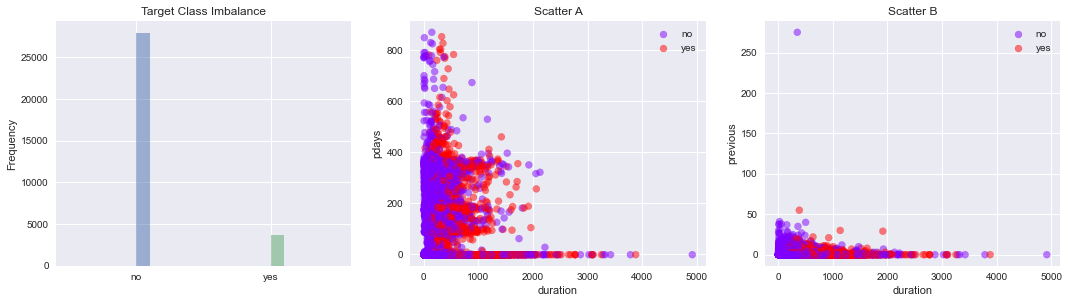

In [49]:
data_exp_fig, axs = plt.subplots(1, 3, figsize=(18, 4.5))
_, ax = class_imbalance_plot.plot(ax=axs[0])
# sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, ax=axs[1])
_, ax = pdays_scatter_plot.plot(ax=axs[1], title="Scatter A")
_, ax = contact_scatter_plot.plot(ax=axs[2], title="Scatter B")

In [50]:
data_exp_fig.savefig(
    "../out/BankData/Data Exploration - Report - B.png",
    bbox_inches='tight',
    dpi=800
)

## Decision Tree

In [9]:
untuned_dt_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced'
)

tuned_dt_clf = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='gini',
    max_depth=9,
    min_samples_split=1100
)

dt_untuned_learning_curve = LearningCurve(untuned_dt_clf, scoring='recall')
dt_untuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
dt_untuned_learning_curve_plot = LearningCurvePlot(experiment=dt_untuned_learning_curve)

dt_tuned_learning_curve = LearningCurve(tuned_dt_clf, scoring='recall')
dt_tuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
dt_tuned_learning_curve_plot = LearningCurvePlot(experiment=dt_tuned_learning_curve)

dt_tuned_cv = CrossValidation(tuned_dt_clf, scoring='recall')
dt_tuned_cv.run(bank_data.X_train, bank_data.y_train)
dt_tuned_cv_folds = CrossValidationFolds(experiment=dt_tuned_cv)

[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    1.0s remaining:   11.5s
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:    1.2s remaining:    2.5s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:    1.3s remaining:    1.0s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    0.0s remaining:    0.5s


[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    0.2s finished


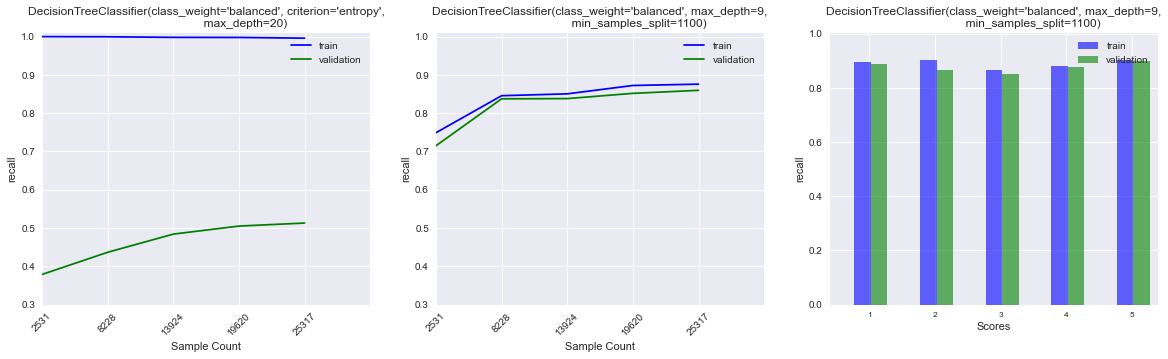

In [10]:
dt_train_curv_fig, axs = plt.subplots(1, 3, figsize=(20, 5))
_, ax = dt_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.3, ymax=1.01)
_, ax = dt_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.3, ymax=1.01)
_, ax = dt_tuned_cv_folds.plot(ax=axs[2])

In [11]:
dt_train_curv_fig.savefig(
    "../out/BankData/DecisionTree/LearningCurves - Report.png",
    bbox_inches='tight',
    dpi=800
)

In [12]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'min_samples_leaf',
    [
        1, 10, 100, 1000
    ],
    scoring='recall',
)
val_curv.run(bank_data.X_train, bank_data.y_train)
min_samples_leaf_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of  20 | elapsed:    0.1s remaining:    2.5s
[Parallel(n_jobs=3)]: Done   6 out of  20 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=3)]: Done  11 out of  20 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=3)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:    0.7s finished


In [13]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'max_depth',
    [
        2, 4, 6, 8, 10, 12
    ],
    scoring='recall',
)
val_curv.run(bank_data.X_train, bank_data.y_train)
max_depth_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  30 | elapsed:    0.1s remaining:    1.1s
[Parallel(n_jobs=3)]: Done  10 out of  30 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=3)]: Done  17 out of  30 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=3)]: Done  24 out of  30 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.8s finished


In [14]:
val_curv = ValidationCurve(
    DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight='balanced'),
    'min_samples_split',
    [
        2, 10, 100, 1000, 1500
    ],
    scoring='recall',
)
val_curv.run(bank_data.X_train, bank_data.y_train)
min_samples_split_plot = ValidationCurvePlot(experiment=val_curv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    0.1s remaining:    1.6s
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:    0.9s finished


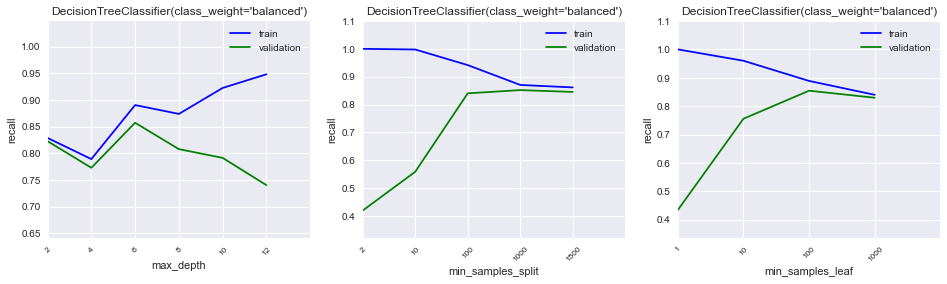

In [15]:
validation_fig, axs = plt.subplots(1, 3, figsize=(16, 4))
_, ax = max_depth_plot.plot(ax=axs[0])
_, ax = min_samples_split_plot.plot(ax=axs[1])
_, ax = min_samples_leaf_plot.plot(ax=axs[2])

In [16]:
validation_fig.savefig(
    "../out/BankData/DecisionTree/ValidationCurves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [18]:
tuned_model_eval = ModelEvaluation(tuned_dt_clf)
tuned_model_eval.run(bank_data.X_train, bank_data.y_train, bank_data.X_test, bank_data.y_test)
print(tuned_model_eval.model)
print(ClassificationReport(experiment=tuned_model_eval).plot())

DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=1100)
              precision    recall  f1-score   support

           0       0.98      0.76      0.85     11966
           1       0.32      0.87      0.47      1598

    accuracy                           0.77     13564
   macro avg       0.65      0.81      0.66     13564
weighted avg       0.90      0.77      0.81     13564



## Support Vector Machine

In [19]:
untuned_svm_clf = LinearSVC(
    C=1.0, max_iter=1000, penalty='l2', dual=False, verbose=0, class_weight='balanced'
)
# SVC(C=0.01, class_weight='balanced', gamma=0.15, verbose=0)
# tuned_svm_clf = SVC(C=0.15, gamma=0.2, kernel='rbf', class_weight='balanced', verbose=0)
tuned_svm_clf = SVC(C=0.1, gamma=0.12, kernel='rbf', class_weight='balanced', verbose=0)

In [20]:
svm_untuned_learning_curve = LearningCurve( 
    untuned_svm_clf, 
    scoring='recall', 
    n_splits=3
)
svm_untuned_learning_curve.run(bank_data.X_train, bank_data.y_train)

[learning_curve] Training set sizes: [ 2109  6856 11603 16350 21098]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:    0.2s finished


True

In [21]:
svm_tuned_learning_curve = LearningCurve( 
    tuned_svm_clf, 
    scoring='recall', 
    n_splits=3
)
svm_tuned_learning_curve.run(bank_data.X_train, bank_data.y_train)

[learning_curve] Training set sizes: [ 2109  6856 11603 16350 21098]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:   17.9s remaining:   49.3s


[CV] END ..................., score=(train=1.000, test=0.376) total time=   0.0s
[CV] END ..................., score=(train=0.998, test=0.494) total time=   0.1s
[CV] END ..................., score=(train=0.994, test=0.522) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.508) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.368) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=0.423) total time=   0.0s
[CV] END ..................., score=(train=0.997, test=0.512) total time=   0.1s
[CV] END ..................., score=(train=0.865, test=0.845) total time=   0.1s
[CV] END ..................., score=(train=0.886, test=0.868) total time=   0.0s
[CV] END ..................., score=(train=0.877, test=0.828) total time=   0.0s
[CV] END ..................., score=(train=0.855, test=0.845) total time=   0.0s
[CV] END ..................., score=(train=0.859, test=0.845) total time=   0.0s
[CV] END ...................

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:   48.4s remaining:   42.3s


[CV] END ..................., score=(train=1.000, test=0.396) total time=   0.0s
[CV] END ..................., score=(train=0.998, test=0.521) total time=   0.1s
[CV] END ..................., score=(train=0.993, test=0.474) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.394) total time=   0.0s
[CV] END ..................., score=(train=0.999, test=0.467) total time=   0.0s
[CV] END ..................., score=(train=0.999, test=0.510) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.456) total time=   0.1s
[CV] END ..................., score=(train=0.992, test=0.491) total time=   0.1s
[CV] END ..................., score=(train=0.627, test=0.598) total time=   0.0s
[CV] END ..................., score=(train=0.840, test=0.820) total time=   0.0s
[CV] END ..................., score=(train=0.620, test=0.590) total time=   0.0s
[CV] END ..................., score=(train=0.767, test=0.774) total time=   0.0s
[CV] END ...................

[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  1.2min remaining:   17.8s


[CV] END ..................., score=(train=0.899, test=0.843) total time=   1.5s
[CV] END ..................., score=(train=0.907, test=0.862) total time=   4.9s
[CV] END ..................., score=(train=0.899, test=0.871) total time=  14.7s
[CV] END ..................., score=(train=0.999, test=0.488) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.412) total time=   0.0s
[CV] END ..................., score=(train=0.999, test=0.475) total time=   0.0s
[CV] END ..................., score=(train=0.996, test=0.496) total time=   0.1s
[CV] END ..................., score=(train=0.999, test=0.500) total time=   0.1s
[CV] END ..................., score=(train=1.000, test=0.324) total time=   0.0s
[CV] END ..................., score=(train=1.000, test=0.442) total time=   0.0s
[CV] END ..................., score=(train=0.999, test=0.487) total time=   0.1s
[CV] END ..................., score=(train=0.999, test=0.503) total time=   0.1s
[CV] END ...................

[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.8min finished


True

In [22]:
svm_tuned_cv = CrossValidation(tuned_svm_clf, scoring='recall')
svm_tuned_cv.run(bank_data.X_train, bank_data.y_train)
svm_tuned_cv_folds = CrossValidationFolds(experiment=svm_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   52.1s remaining:  1.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.7min finished


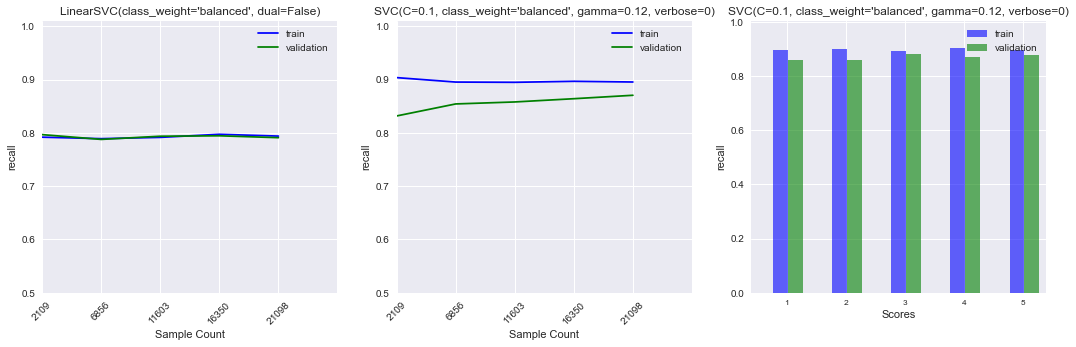

In [23]:
svm_untuned_learning_curve_plot = LearningCurvePlot(experiment=svm_untuned_learning_curve)
svm_tuned_learning_curve_plot = LearningCurvePlot(experiment=svm_tuned_learning_curve)

svm_learning_curves_fig, axs = plt.subplots(1, 3, figsize=(18, 5))
_, ax = svm_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.5, ymax=1.01)
_, ax = svm_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.5, ymax=1.01)
_, ax = svm_tuned_cv_folds.plot(ax=axs[2])

In [24]:
svm_learning_curves_fig.savefig(
    "../out/BankData/SVM/LearningCurves - Report.png",
    bbox_inches='tight',
    dpi=800
)

In [25]:
svc_C_val_curv = ValidationCurve(
    SVC(gamma=0.1, kernel='rbf', class_weight='balanced', verbose=0),
    'C', 
    [0.001, 0.01, 0.1, 1.0, 10],
    scoring='recall',
    n_splits=3
)
svc_C_val_curv.run(bank_data.X_train, bank_data.y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:  1.4min remaining:  3.7min
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:  2.5min remaining:  2.2min
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:  3.6min remaining:   53.4s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  4.1min finished


True

In [26]:
svc_gamma_val_curv = ValidationCurve(
    SVC(C=0.1, kernel='rbf', class_weight='balanced', verbose=0),
    'gamma', 
    [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0],
    scoring='recall',
    n_splits=3
)
svc_gamma_val_curv.run(bank_data.X_train, bank_data.y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[CV] END ..................., score=(train=0.897, test=0.877) total time=  22.3s
[CV] END ..................., score=(train=0.898, test=0.859) total time=  26.1s
[CV] END ...........C=0.001;, score=(train=0.919, test=0.928) total time=  42.4s
[CV] END ............C=0.01;, score=(train=0.862, test=0.868) total time=  30.5s
[CV] END ..............C=10;, score=(train=0.982, test=0.700) total time=  19.9s
[CV] END .............C=0.1;, score=(train=0.889, test=0.846) total time=  21.2s
[CV] END .............C=1.0;, score=(train=0.937, test=0.824) total time=  17.8s
[CV] END ........gamma=0.05;, score=(train=0.868, test=0.850) total time=  21.8s


[Parallel(n_jobs=3)]: Done   2 out of  21 | elapsed:   41.0s remaining:  6.5min
[Parallel(n_jobs=3)]: Done   7 out of  21 | elapsed:  3.0min remaining:  6.1min


[CV] END .........gamma=1.0;, score=(train=0.995, test=0.983) total time=  56.6s
[CV] END ........gamma=0.05;, score=(train=0.862, test=0.863) total time=  24.1s
[CV] END .........gamma=0.1;, score=(train=0.886, test=0.878) total time=  24.0s


[Parallel(n_jobs=3)]: Done  12 out of  21 | elapsed:  4.8min remaining:  3.6min


[CV] END .........gamma=1.5;, score=(train=0.999, test=0.994) total time=  53.7s
[CV] END ........gamma=0.05;, score=(train=0.861, test=0.840) total time=  24.0s


[Parallel(n_jobs=3)]: Done  17 out of  21 | elapsed:  6.3min remaining:  1.5min
[Parallel(n_jobs=3)]: Done  21 out of  21 | elapsed:  8.4min finished


True

In [28]:
svc_C_val_curv_plot = ValidationCurvePlot(experiment=svc_C_val_curv)
svc_gamma_val_curv_plot = ValidationCurvePlot(experiment=svc_gamma_val_curv)

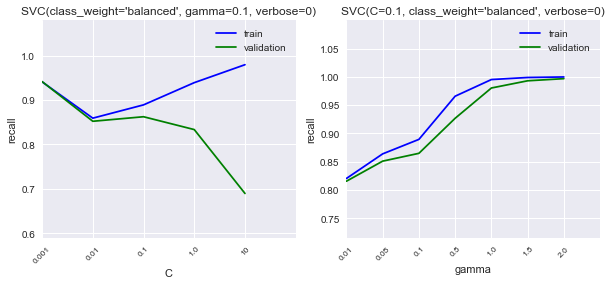

In [69]:
svc_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_, ax = svc_C_val_curv_plot.plot(ax=axs[0])
_, ax = svc_gamma_val_curv_plot.plot(ax=axs[1])

In [70]:
svc_val_curvs_fig.savefig(
    "../out/BankData/SVM/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [31]:
tuned_model_eval = ModelEvaluation(tuned_svm_clf)
tuned_model_eval.run(bank_data.X_train, bank_data.y_train, bank_data.X_test, bank_data.y_test)
print(tuned_model_eval.model)
print(ClassificationReport(experiment=tuned_model_eval).plot())

SVC(C=0.1, class_weight='balanced', gamma=0.12, verbose=0)
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     11966
           1       0.38      0.88      0.53      1598

    accuracy                           0.81     13564
   macro avg       0.68      0.84      0.71     13564
weighted avg       0.91      0.81      0.84     13564



## k-Nearest Neighbors

In [32]:
knn_untuned_clf = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)
knn_tuned_clf = KNeighborsClassifier(n_neighbors=6, weights='uniform', p=2)

In [33]:
knn_tuned_cv = CrossValidation(knn_tuned_clf, scoring='recall')
knn_tuned_cv.run(bank_data.X_train, bank_data.y_train)
knn_tuned_cv_folds = CrossValidationFolds(experiment=knn_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will bec

In [34]:
knn_untuned_learning_curve = LearningCurve(knn_untuned_clf, scoring='recall')
knn_untuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
knn_untuned_learning_curve_plot = LearningCurvePlot(experiment=knn_untuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

In [35]:
knn_tuned_learning_curve = LearningCurve(knn_tuned_clf, scoring='recall')
knn_tuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
knn_tuned_learning_curve_plot = LearningCurvePlot(experiment=knn_tuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:   10.7s remaining:    8.4s
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` wil

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

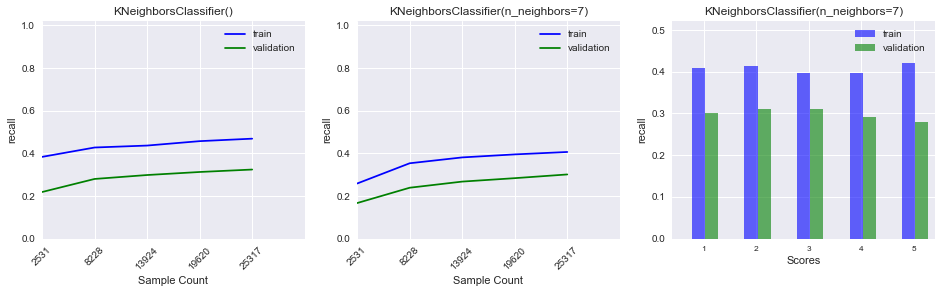

In [36]:
knn_train_curv_fig, axs = plt.subplots(1, 3, figsize=(16, 4))
_, ax = knn_untuned_learning_curve_plot.plot(ax=axs[0], ymin=0.0, ymax=1.02)
_, ax = knn_tuned_learning_curve_plot.plot(ax=axs[1], ymin=0.0, ymax=1.02)
_, ax = knn_tuned_cv_folds.plot(ax=axs[2])

In [37]:
knn_train_curv_fig.savefig(
    "../out/BankData/KNN/Training Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [38]:
uniform_val_curv = ValidationCurve(
    KNeighborsClassifier(weights='uniform', p=2),
    'n_neighbors', 
    np.arange(2, 45, 5),
    scoring='recall'
)
uniform_val_curv.run(bank_data.X_train, bank_data.y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will bec

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  1.2min finished


True

In [39]:
distance_val_curv = ValidationCurve(
    KNeighborsClassifier(weights='distance', p=2, algorithm='ball_tree', leaf_size=1000),
    'n_neighbors', 
    np.arange(1, 13, 2),
    scoring='recall',
    n_splits=3
)
distance_val_curv.run(bank_data.X_train, bank_data.y_train)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of  18 | elapsed:   16.6s remaining:  1.4min
[Parallel(n_jobs=3)]: Done   7 out of  18 | elapsed:   59.1s remaining:  1.5min
[Parallel(n_jobs=3)]: Done  11 out of  18 | elapsed:  1.4min remaining:   53.2s
[Parallel(n_jobs=3)]: Done  15 out of  18 | elapsed:  1.8min remaining:   21.6s
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:  2.2min finished


True

In [40]:
uniform_val_curv_plot = ValidationCurvePlot(experiment=uniform_val_curv)
distance_val_curv_plot = ValidationCurvePlot(experiment=distance_val_curv)

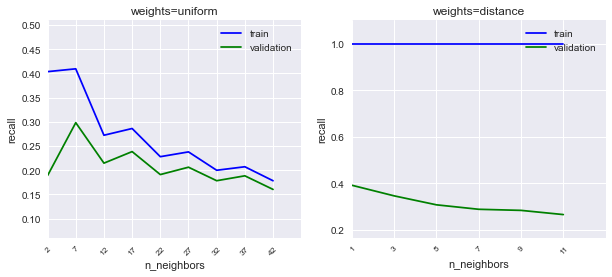

In [71]:
knn_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_, ax = uniform_val_curv_plot.plot(ax=axs[0], title="weights=uniform")
_, ax = distance_val_curv_plot.plot(ax=axs[1], title="weights=distance")

In [72]:
knn_val_curvs_fig.savefig(
    "../out/BankData/KNN/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

[CV] END ..................., score=(train=0.889, test=0.723) total time=   0.8s
[CV] END ..................., score=(train=0.846, test=0.836) total time=   3.7s
[CV] END ..................., score=(train=0.859, test=0.792) total time=   2.8s
[CV] END ..................., score=(train=0.908, test=0.675) total time=   0.9s
[CV] END ..................., score=(train=0.856, test=0.797) total time=   1.8s
[CV] END ..................., score=(train=0.851, test=0.809) total time=   3.7s
[CV] END ..................., score=(train=0.843, test=0.818) total time=   2.8s
[CV] END ..................., score=(train=0.916, test=0.692) total time=   0.9s
[CV] END ..................., score=(train=0.851, test=0.797) total time=   1.8s
[CV] END ..................., score=(train=0.841, test=0.824) total time=   3.7s
[CV] END ..................., score=(train=0.880, test=0.878) total time=   9.2s
[CV] END ..................., score=(train=0.000, test=0.000) total time=   1.1s
[CV] END ...................

In [43]:
knn_tuned_model_eval = ModelEvaluation(knn_tuned_clf)
knn_tuned_model_eval.run(bank_data.X_train, bank_data.y_train, bank_data.X_test, bank_data.y_test)
print(knn_tuned_model_eval.model)
print(ClassificationReport(experiment=knn_tuned_model_eval).plot())

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNeighborsClassifier(n_neighbors=7)
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     11966
           1       0.58      0.30      0.40      1598

    accuracy                           0.89     13564
   macro avg       0.75      0.64      0.67     13564
weighted avg       0.87      0.89      0.88     13564



## AdaBoost

In [53]:
dstump = DecisionTreeClassifier(max_depth=1, class_weight='balanced')
ada_untuned_clf = AdaBoostClassifier(base_estimator=dstump, n_estimators=300, learning_rate=1.0)
tuned_weak = DecisionTreeClassifier(class_weight='balanced', min_samples_split=8000)
ada_tuned_clf = AdaBoostClassifier(base_estimator=tuned_weak, n_estimators=500, learning_rate=0.01)

In [54]:
ada_untuned_learning_curve = LearningCurve(ada_untuned_clf, scoring='recall')
ada_untuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
ada_untuned_learning_curve_plot = LearningCurvePlot(experiment=ada_untuned_learning_curve)

[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    2.8s remaining:   31.9s
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:    9.0s remaining:   19.1s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:   15.0s remaining:   11.8s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:   21.2s remaining:    5.3s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:   28.8s finished


In [55]:
ada_tuned_learning_curve = LearningCurve(ada_tuned_clf, scoring='recall')
ada_tuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
ada_tuned_learning_curve_plot = LearningCurvePlot(experiment=ada_tuned_learning_curve)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


[Parallel(n_jobs=3)]: Done   2 out of  25 | elapsed:    3.8s remaining:   43.7s
[Parallel(n_jobs=3)]: Done   8 out of  25 | elapsed:   26.7s remaining:   56.7s
[Parallel(n_jobs=3)]: Done  14 out of  25 | elapsed:   48.1s remaining:   37.8s
[Parallel(n_jobs=3)]: Done  20 out of  25 | elapsed:  1.1min remaining:   17.0s
[Parallel(n_jobs=3)]: Done  25 out of  25 | elapsed:  1.6min finished


In [56]:
ada_tuned_cv = CrossValidation(ada_tuned_clf, scoring='recall')
ada_tuned_cv.run(bank_data.X_train, bank_data.y_train)
ada_tuned_cv_folds = CrossValidationFolds(experiment=ada_tuned_cv)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   22.0s remaining:   33.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   42.4s finished


In [57]:
boost_iter = BoostingIterations(ada_tuned_clf, scoring='recall')
boost_iter.run(bank_data.X_train, bank_data.y_train)
boost_iter_plot = BoostingIterationsPlot(experiment=boost_iter)

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, 

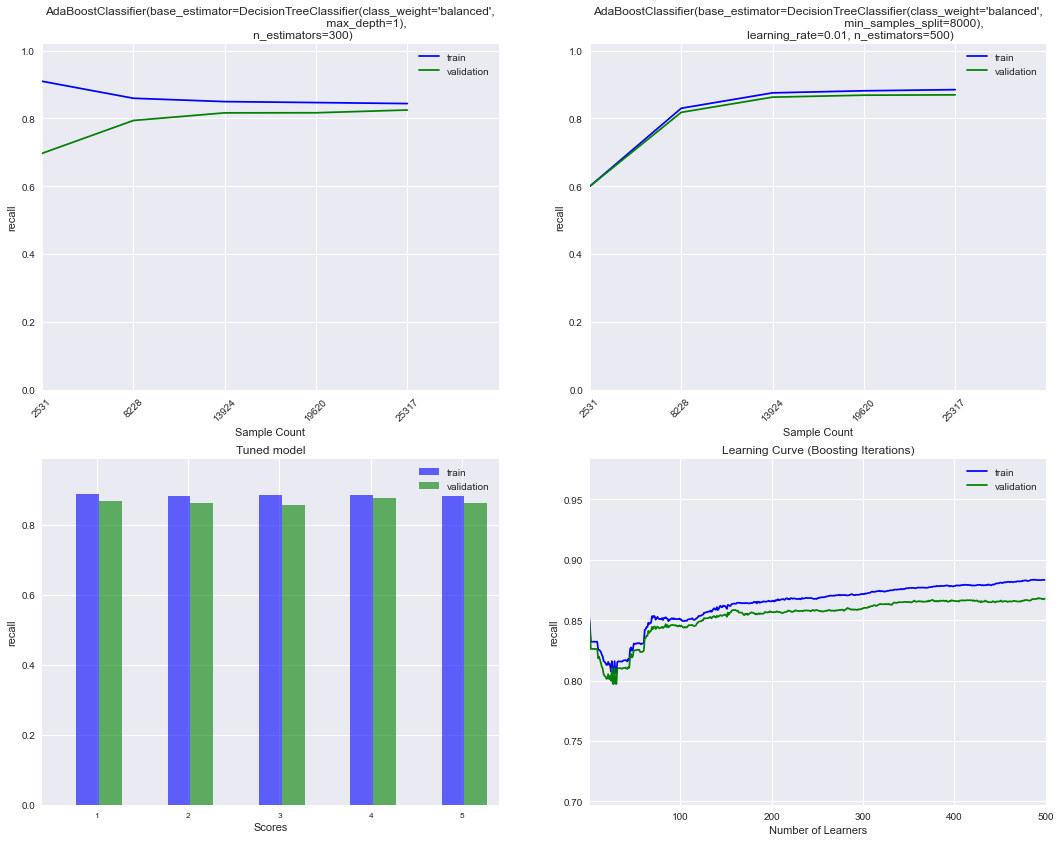

In [58]:
ada_train_curv_fig, axs = plt.subplots(2, 2, figsize=(18, 14))
_, ax = ada_untuned_learning_curve_plot.plot(ax=axs[0][0], ymin=0.0, ymax=1.02)
_, ax = ada_tuned_learning_curve_plot.plot(ax=axs[0][1], ymin=0.0, ymax=1.02)
_, ax = ada_tuned_cv_folds.plot(title="Tuned model", ax=axs[1][0])
_, ax = boost_iter_plot.plot(ax=axs[1][1])

In [59]:
ada_train_curv_fig.savefig(
    "../out/BankData/AdaBoost/Learning Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [60]:
dt = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=1500)
ada_clf = AdaBoostClassifier(base_estimator=dt, learning_rate=0.0001)

ada_val_curv_A = ValidationCurve(
    ada_clf,
    'n_estimators',
    np.arange(100, 600, 100),
    scoring='recall',
    n_splits=3
)
ada_val_curv_A.run(bank_data.X_train, bank_data.y_train)
ada_val_curv_A_plot = ValidationCurvePlot(experiment=ada_val_curv_A)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:   14.4s remaining:   39.6s
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:   29.0s remaining:   25.4s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:   43.2s remaining:   10.8s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   60.0s finished


In [61]:
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=1)
ada_clf = AdaBoostClassifier(base_estimator=dt, learning_rate=1.0)

ada_val_curv_B = ValidationCurve(
    ada_clf,
    'n_estimators',
    np.arange(100, 600, 100),
    scoring='recall',
    n_splits=3
)
ada_val_curv_B.run(bank_data.X_train, bank_data.y_train)
ada_val_curv_B_plot = ValidationCurvePlot(experiment=ada_val_curv_B)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of  15 | elapsed:    6.6s remaining:   18.2s
[Parallel(n_jobs=3)]: Done   8 out of  15 | elapsed:   13.5s remaining:   11.8s
[Parallel(n_jobs=3)]: Done  12 out of  15 | elapsed:   19.8s remaining:    5.0s
[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:   28.0s finished


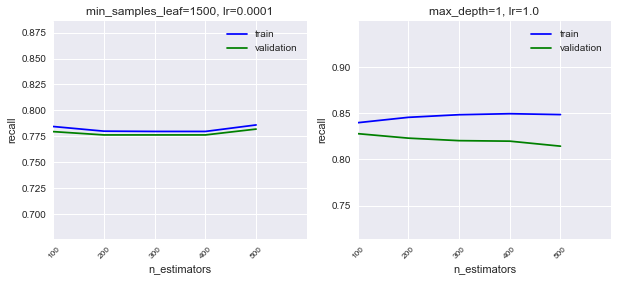

In [74]:
ada_val_curvs_fig, axs = plt.subplots(1, 2, figsize=(10, 4))
_, ax = ada_val_curv_A_plot.plot(ax=axs[0], title="min_samples_leaf=1500, lr=0.0001")
_, ax = ada_val_curv_B_plot.plot(ax=axs[1], title="max_depth=1, lr=1.0")

In [75]:
ada_val_curvs_fig.savefig(
    "../out/BankData/AdaBoost/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [76]:
ada_tuned_model_eval = ModelEvaluation(ada_tuned_clf)
ada_tuned_model_eval.run(bank_data.X_train, bank_data.y_train, bank_data.X_test, bank_data.y_test)
print(ada_tuned_model_eval.model)
print(ClassificationReport(experiment=ada_tuned_model_eval).plot())

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         min_samples_split=8000),
                   learning_rate=0.01, n_estimators=500)
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     11966
           1       0.39      0.88      0.54      1598

    accuracy                           0.82     13564
   macro avg       0.68      0.85      0.72     13564
weighted avg       0.91      0.82      0.85     13564



## Neural Network

In [81]:
nn_untuned_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=26, 
    epochs=10, 
    activation_fn=nn.ReLU,
    learning_rate=0.1,
    verbose=True
)
nn_tuned_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=26, 
    epochs=20, 
    activation_fn=nn.ReLU,
    learning_rate=0.4,
    verbose=True
)

In [78]:
nn_untuned_learning_curve = LearningCurve(nn_untuned_clf, scoring='recall', n_splits=3)
nn_untuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
nn_untuned_learning_curve_plot = LearningCurvePlot(experiment=nn_untuned_learning_curve)

[learning_curve] Training set sizes: [ 2531  8228 13924 19620 25317]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  2.5577422380447388
Epoch:  1  -  0.9792777299880981
Epoch:  2  -  0.7965291142463684
Epoch:  3  -  0.686598559220632
Epoch:  4  -  0.6087074478467306
Epoch:  5  -  0.5535342892011007
Epoch:  6  -  0.5123155315717062
Epoch:  7  -  0.48041556278864544
Epoch:  8  -  0.455030898253123
Epoch:  9  -  0.4344082276026408
[CV] END ..................., score=(train=0.000, test=0.000) total time=   6.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


Epoch:  0  -  1.5872431728574965
Epoch:  1  -  0.9954489800665114
Epoch:  2  -  0.9042243096563551
Epoch:  3  -  0.8373245398203532
Epoch:  4  -  0.7930371165275574
Epoch:  5  -  0.7651959525214301
Epoch:  6  -  0.7471495138274299
Epoch:  7  -  0.7344806459214952
Epoch:  8  -  0.7248642444610596
Epoch:  9  -  0.7173166275024414
[CV] END ..................., score=(train=0.000, test=0.000) total time=  17.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.4s remaining:    0.0s


Epoch:  0  -  1.488495111465454
Epoch:  1  -  0.9311775352273669
Epoch:  2  -  0.8279782576220376
Epoch:  3  -  0.7683614279542651
Epoch:  4  -  0.6295264916760581
Epoch:  5  -  0.42509626277855467
Epoch:  6  -  0.3513292052916118
Epoch:  7  -  0.3262424703155245
Epoch:  8  -  0.31202382913657595
Epoch:  9  -  0.30254737607070376
[CV] END ..................., score=(train=0.159, test=0.194) total time=  28.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.3s remaining:    0.0s


Epoch:  0  -  3.286826264858246
Epoch:  1  -  3.2430065870285034
Epoch:  2  -  3.205797564983368
Epoch:  3  -  3.1875803470611572
Epoch:  4  -  3.1701732158660887
Epoch:  5  -  3.154054570198059
Epoch:  6  -  3.141127908229828
Epoch:  7  -  3.1319280743598936
Epoch:  8  -  2.0802779674530028
Epoch:  9  -  0.4240242332220078
[CV] END ..................., score=(train=0.268, test=0.281) total time=  40.9s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


Epoch:  0  -  1.2226403069496155
Epoch:  1  -  0.41974451780319216
Epoch:  2  -  0.35209141254425047
Epoch:  3  -  0.31791004419326785
Epoch:  4  -  0.2977332735061646
Epoch:  5  -  0.2953124415874481
Epoch:  6  -  0.2933749485015869
Epoch:  7  -  0.28438588976860046
Epoch:  8  -  0.2791667139530182
Epoch:  9  -  0.2753679406642914
[CV] END ..................., score=(train=0.141, test=0.165) total time=  52.4s
Epoch:  0  -  2.2717760801315308
Epoch:  1  -  1.0450480779012044
Epoch:  2  -  0.879941463470459
Epoch:  3  -  0.7580103079477946
Epoch:  4  -  0.6555282473564148
Epoch:  5  -  0.5800627867380778
Epoch:  6  -  0.527796228726705
Epoch:  7  -  0.4899805982907613
Epoch:  8  -  0.4613751471042633
Epoch:  9  -  0.4390012323856354
[CV] END ..................., score=(train=0.000, test=0.001) total time=   5.5s
Epoch:  0  -  2.202928476863437
Epoch:  1  -  1.1040876176622179
Epoch:  2  -  1.000026351875729
Epoch:  3  -  0.9146323137813144
Epoch:  4  -  0.8476954897244772
Epoch:  5  - 

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fs

Epoch:  0  -  1.3081960933549064
Epoch:  1  -  0.5909576607601983
Epoch:  2  -  0.4368777871131897
Epoch:  3  -  0.3844607493707112
Epoch:  4  -  0.35345681650297983
Epoch:  5  -  0.33159026716436657
Epoch:  6  -  0.31601024525506155
Epoch:  7  -  0.30515209478991373
Epoch:  8  -  0.29747035035065245
Epoch:  9  -  0.29183247472558704
[CV] END ..................., score=(train=0.180, test=0.159) total time=  28.0s
Epoch:  0  -  1.0073651671409607
Epoch:  1  -  0.4638639748096466
Epoch:  2  -  0.38957628756761553
Epoch:  3  -  0.353142948448658
Epoch:  4  -  0.3271497443318367
Epoch:  5  -  0.3080501690506935
Epoch:  6  -  0.29468198120594025
Epoch:  7  -  0.2857135832309723
Epoch:  8  -  0.29013907015323637
Epoch:  9  -  0.2870535641908646
[CV] END ..................., score=(train=0.295, test=0.293) total time=  39.2s
Epoch:  0  -  1.4501352310180664
Epoch:  1  -  0.7884522676467896
Epoch:  2  -  0.7138313364982605
Epoch:  3  -  0.6324289798736572
Epoch:  4  -  0.3596114706993103
Epoch

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fs

Epoch:  0  -  2.8124849001566568
Epoch:  1  -  1.119124412536621
Epoch:  2  -  0.9918184479077657
Epoch:  3  -  0.9040589928627014
Epoch:  4  -  0.7786411643028259
Epoch:  5  -  0.664069930712382
Epoch:  6  -  0.5751890341440836
Epoch:  7  -  0.515462319056193
Epoch:  8  -  0.4746618866920471
Epoch:  9  -  0.4449971417586009
[CV] END ..................., score=(train=0.000, test=0.006) total time=   4.9s
Epoch:  0  -  1.3045303556654189
Epoch:  1  -  0.6218606498506334
Epoch:  2  -  0.4860234326786465
Epoch:  3  -  0.4238731629318661
Epoch:  4  -  0.3862309257189433
Epoch:  5  -  0.3600506948100196
Epoch:  6  -  0.3405926823616028
Epoch:  7  -  0.32552681035465664
Epoch:  8  -  0.3136156565613217
Epoch:  9  -  0.3041978312863244
[CV] END ..................., score=(train=0.081, test=0.081) total time=  16.2s
Epoch:  0  -  2.727629746709551
Epoch:  1  -  1.0664955590452467
Epoch:  2  -  0.905111768415996
Epoch:  3  -  0.7937084521566119
Epoch:  4  -  0.7000004606587547
Epoch:  5  -  0.4

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 11.6min finished


In [83]:
nn_tuned_learning_curve = LearningCurve(nn_tuned_clf, scoring='recall', n_splits=3)
nn_tuned_learning_curve.run(bank_data.X_train, bank_data.y_train)
nn_tuned_learning_curve_plot = LearningCurvePlot(experiment=nn_tuned_learning_curve)

[learning_curve] Training set sizes: [ 2109  6856 11603 16350 21098]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  2.639387925465902
Epoch:  1  -  0.8175022403399149
Epoch:  2  -  0.6460374196370443
Epoch:  3  -  0.49177552262942
Epoch:  4  -  0.4623391926288605
Epoch:  5  -  0.5005671282609304
Epoch:  6  -  0.33827600876490277
Epoch:  7  -  0.3206392129262288
Epoch:  8  -  0.4650322000185649
Epoch:  9  -  0.3322722216447194
Epoch:  10  -  0.374385267496109
Epoch:  11  -  0.35175689061482746
Epoch:  12  -  0.3455524941285451
Epoch:  13  -  0.32413679361343384
Epoch:  14  -  0.3293729325135549
Epoch:  15  -  0.3134170174598694
Epoch:  16  -  0.31719324986139935
Epoch:  17  -  0.30431174238522846
Epoch:  18  -  0.30825082461039227
Epoch:  19  -  0.2970251441001892
[CV] END ..................., score=(train=0.068, test=0.058) total time=   8.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


Epoch:  0  -  1.0782709802900041
Epoch:  1  -  0.5945313274860382
Epoch:  2  -  0.45528161099978853
Epoch:  3  -  0.36980111684118
Epoch:  4  -  0.35110280343464445
Epoch:  5  -  0.3392828915800367
Epoch:  6  -  0.3221657020705087
Epoch:  7  -  0.3150673338345119
Epoch:  8  -  0.30487642117909025
Epoch:  9  -  0.30127992800303866
Epoch:  10  -  0.29448916230882916
Epoch:  11  -  0.2922781876155308
Epoch:  12  -  0.28761622309684753
Epoch:  13  -  0.28583412936755587
Epoch:  14  -  0.282534978219441
Epoch:  15  -  0.2815606764384678
Epoch:  16  -  0.278182715177536
Epoch:  17  -  0.2773615206990923
Epoch:  18  -  0.27519701208387104
Epoch:  19  -  0.27489299859319416
[CV] END ..................., score=(train=0.350, test=0.341) total time=  26.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.8s remaining:    0.0s


Epoch:  0  -  1.4876457701126735
Epoch:  1  -  0.8043307165304819
Epoch:  2  -  0.7357591142257055
Epoch:  3  -  0.6947513421376547
Epoch:  4  -  0.5594722057382265
Epoch:  5  -  0.3639550084869067
Epoch:  6  -  0.3318732629219691
Epoch:  7  -  0.30809209992488223
Epoch:  8  -  0.29608310510714847
Epoch:  9  -  0.2884262949228287
Epoch:  10  -  0.2830406278371811
Epoch:  11  -  0.27908794830242795
Epoch:  12  -  0.27629608164230984
Epoch:  13  -  0.2740613172451655
Epoch:  14  -  0.2718448390563329
Epoch:  15  -  0.2702421893676122
Epoch:  16  -  0.26873333007097244
Epoch:  17  -  0.26726700117190677
Epoch:  18  -  0.2658486192425092
Epoch:  19  -  0.26514245321353275
[CV] END ..................., score=(train=0.112, test=0.092) total time=  44.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


Epoch:  0  -  0.8242849409580231
Epoch:  1  -  0.40158560313284397
Epoch:  2  -  0.3479731157422066
Epoch:  3  -  0.3227799981832504
Epoch:  4  -  0.30825125612318516
Epoch:  5  -  0.2984012421220541
Epoch:  6  -  0.29126434214413166
Epoch:  7  -  0.2858573067933321
Epoch:  8  -  0.28129393979907036
Epoch:  9  -  0.2774672172963619
Epoch:  10  -  0.2743783500045538
Epoch:  11  -  0.27167146280407906
Epoch:  12  -  0.269604554399848
Epoch:  13  -  0.2675497308373451
Epoch:  14  -  0.2659762855619192
Epoch:  15  -  0.2644754685461521
Epoch:  16  -  0.26339758560061455
Epoch:  17  -  0.26222042739391327
Epoch:  18  -  0.2613461222499609
Epoch:  19  -  0.2603937052190304
[CV] END ..................., score=(train=0.363, test=0.352) total time= 1.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.4min remaining:    0.0s


Epoch:  0  -  1.6791880017235166
Epoch:  1  -  0.7109307419686091
Epoch:  2  -  0.4982841852165404
Epoch:  3  -  0.36433481460525874
Epoch:  4  -  0.3177842426867712
Epoch:  5  -  0.297396692491713
Epoch:  6  -  0.28517896078881766
Epoch:  7  -  0.27885243154707406
Epoch:  8  -  0.27397515660240535
Epoch:  9  -  0.271175864196959
Epoch:  10  -  0.2684027169431959
Epoch:  11  -  0.2666894566445124
Epoch:  12  -  0.265085749682926
Epoch:  13  -  0.26386386156082153
Epoch:  14  -  0.26267162674949285
Epoch:  15  -  0.26183680977140156
Epoch:  16  -  0.26066006081444876
Epoch:  17  -  0.2601502963474819
Epoch:  18  -  0.2592239621139708
Epoch:  19  -  0.2586238497779483
[CV] END ..................., score=(train=0.404, test=0.399) total time= 1.4min
Epoch:  0  -  1.764414111773173
Epoch:  1  -  0.9575902819633484
Epoch:  2  -  0.7953433195749918
Epoch:  3  -  0.5262818932533264
Epoch:  4  -  0.3864094316959381
Epoch:  5  -  0.5323422948519388
Epoch:  6  -  0.4142295519510905
Epoch:  7  -  

Epoch:  19  -  0.25415719406945364
[CV] END ..................., score=(train=0.428, test=0.423) total time= 1.4min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 11.2min finished


In [84]:
nn_tuned_cv = CrossValidation(nn_tuned_clf, scoring='recall', n_splits=3)
nn_tuned_cv.run(bank_data.X_train, bank_data.y_train)
nn_tuned_cv_folds = CrossValidationFolds(experiment=nn_tuned_cv)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  0.8483767339161464
Epoch:  1  -  0.3682136606602442
Epoch:  2  -  0.32393662134806317
Epoch:  3  -  0.3031987335000719
Epoch:  4  -  0.2903886352266584
Epoch:  5  -  0.2828566247508639
Epoch:  6  -  0.2769152025381724
Epoch:  7  -  0.27341797380220323
Epoch:  8  -  0.26974827760741826
Epoch:  9  -  0.26750131448109943
Epoch:  10  -  0.26505845359393526
Epoch:  11  -  0.2635416246595837
Epoch:  12  -  0.26178736488024396
Epoch:  13  -  0.26069651615052
Epoch:  14  -  0.2596464554468791
Epoch:  15  -  0.2588792358125959
Epoch:  16  -  0.2578944776739393
Epoch:  17  -  0.25719973019191195
Epoch:  18  -  0.2564770664487566
Epoch:  19  -  0.25607994340714957
[CV] END ..................., score=(train=0.415, test=0.410) total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


Epoch:  0  -  0.8416769731612432
Epoch:  1  -  0.39801946140470956
Epoch:  2  -  0.3294780410471417
Epoch:  3  -  0.3028519678683508
Epoch:  4  -  0.29022408099401564
Epoch:  5  -  0.28121152945927214
Epoch:  6  -  0.27556409580366953
Epoch:  7  -  0.2711305447987148
Epoch:  8  -  0.2682982314200628
Epoch:  9  -  0.2653927150226775
Epoch:  10  -  0.26353579333850313
Epoch:  11  -  0.26173208015305655
Epoch:  12  -  0.2602868732951936
Epoch:  13  -  0.2588512471743992
Epoch:  14  -  0.2580106584798722
Epoch:  15  -  0.25679590588524226
Epoch:  16  -  0.25602221488952637
Epoch:  17  -  0.2551650731336503
Epoch:  18  -  0.254700148389453
Epoch:  19  -  0.254157318955376
[CV] END ..................., score=(train=0.109, test=0.116) total time= 1.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s


Epoch:  0  -  0.7342654480820611
Epoch:  1  -  0.34954685256594703
Epoch:  2  -  0.3185902266275315
Epoch:  3  -  0.29726519613038926
Epoch:  4  -  0.28449422688711257
Epoch:  5  -  0.2776951278959002
Epoch:  6  -  0.2724152547972543
Epoch:  7  -  0.2692501601718721
Epoch:  8  -  0.26609400908152264
Epoch:  9  -  0.26398296157519024
Epoch:  10  -  0.2619019704205649
Epoch:  11  -  0.2606245009672074
Epoch:  12  -  0.2592252521287827
Epoch:  13  -  0.25803726201965693
Epoch:  14  -  0.2569302348863511
Epoch:  15  -  0.2560726134550004
Epoch:  16  -  0.2552405652545747
Epoch:  17  -  0.2546070587067377
Epoch:  18  -  0.25376508349464055
Epoch:  19  -  0.2532551359562647
[CV] END ..................., score=(train=0.398, test=0.387) total time= 2.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.9min finished


In [91]:
epochs_nn_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=50, 
    epochs=30, 
    verbose=True,
    learning_rate=0.0001,
    activation_fn=nn.ELU
)
tuned_learning_curve_epochs = LearningCurveEpochs(
    epochs_nn_clf, 
    scoring='cross-entropy',
    n_splits=3
)
tuned_learning_curve_epochs.run(bank_data.X_train, bank_data.y_train)
tuned_learning_curve_epochs_plot = LearningEpochsCurvePlot(experiment=tuned_learning_curve_epochs)

Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 4.105588436126709
test: 4.058567047119141
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 4.066752229418073
test: 4.024871826171875
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 4.024530160994757
test: 3.987595796585083
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Ba

Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 2.6724291188376292
test: 2.789285898208618
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 2.6273427917843772
test: 2.7528440952301025
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 2.580811023712158
test: 2.7088441848754883
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 2.5337371712639216
test: 2.6

Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 1.5088143348693848
test: 1.787598967552185
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 1.4790064493815105
test: 1.77195405960083
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 1.4478028331484114
test: 1.780416488647461
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8
Batch:  9
Batch:  10
Batch:  11
Batch:  12
Batch:  13
Batch:  14
Batch:  15
Batch:  16
Batch:  17
Batch:  18
Batch:  19
Batch:  20
train: 1.4227585338410877
test: 1.7504488229751587
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4

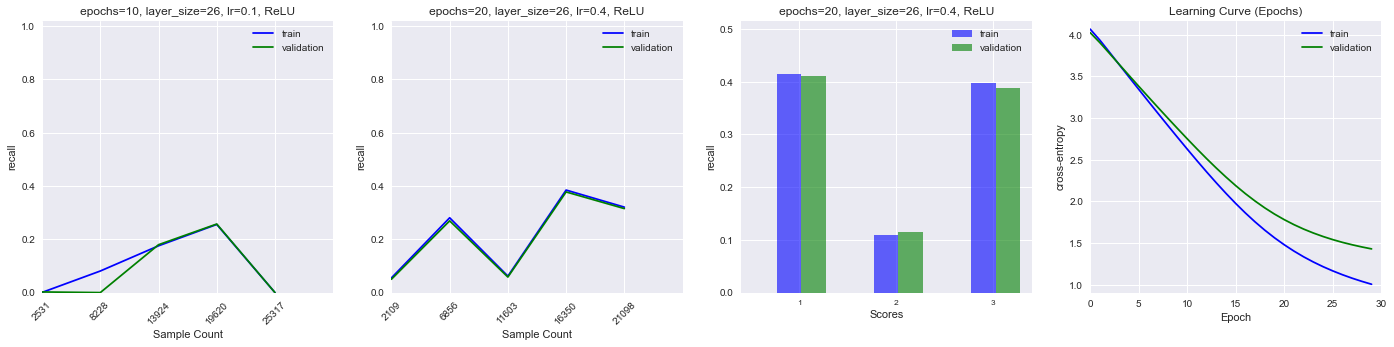

In [104]:
nn_train_curv_fig, axs = plt.subplots(1, 4, figsize=(24, 5))
_, ax = nn_untuned_learning_curve_plot.plot(ax=axs[0], title="epochs=10, layer_size=26, lr=0.1, ReLU", ymin=0.0, ymax=1.02)
_, ax = nn_tuned_learning_curve_plot.plot(ax=axs[1], title="epochs=20, layer_size=26, lr=0.4, ReLU", ymin=0.0, ymax=1.02)
_, ax = nn_tuned_cv_folds.plot(ax=axs[2], title="epochs=20, layer_size=26, lr=0.4, ReLU")
_, ax = tuned_learning_curve_epochs_plot.plot(ax=axs[3])

In [105]:
nn_train_curv_fig.savefig(
    "../out/BankData/NeuralNetwork/Learning Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [106]:
nn_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=25, 
    epochs=8, 
    activation_fn=nn.ReLU,
    learning_rate=0.4,
    verbose=True
)
nn_val_curv_relu_lr = ValidationCurve(
    nn_clf,
    'learning_rate', 
    [0.1, 0.2, 0.3, 0.4, 0.5],
    scoring='recall',
    n_splits=3,
)
nn_val_curv_relu_lr.run(bank_data.X_train, bank_data.y_train)
nn_val_curv_relu_lr_plot = ValidationCurvePlot(experiment=nn_val_curv_relu_lr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  0.6717151048637572
Epoch:  1  -  0.37919818787347703
Epoch:  2  -  0.32924302844774156
Epoch:  3  -  0.30407660064243136
Epoch:  4  -  0.28946902354558307
Epoch:  5  -  0.2815539354369754
Epoch:  6  -  0.2750778907821292
Epoch:  7  -  0.2711694339911143
[CV] END .learning_rate=0.1;, score=(train=0.374, test=0.358) total time=  32.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.7s remaining:    0.0s


Epoch:  0  -  0.8881317107450395
Epoch:  1  -  0.4046855668226878
Epoch:  2  -  0.3341421541713533
Epoch:  3  -  0.3097350625764756
Epoch:  4  -  0.2949764189266023
Epoch:  5  -  0.28693646618298124
Epoch:  6  -  0.28047660418919157
Epoch:  7  -  0.2765545234793708
[CV] END .learning_rate=0.2;, score=(train=0.370, test=0.359) total time=  33.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


Epoch:  0  -  3.237289996374221
Epoch:  1  -  3.2209983439672563
Epoch:  2  -  1.2654567616326469
Epoch:  3  -  0.7135573426882426
Epoch:  4  -  0.6869592184112185
Epoch:  5  -  0.666396282968067
Epoch:  6  -  0.655677596728007
Epoch:  7  -  0.6481562852859497
[CV] END .learning_rate=0.3;, score=(train=0.000, test=0.000) total time=  33.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


Epoch:  0  -  1.1473003696827662
Epoch:  1  -  0.7100270418893724
Epoch:  2  -  0.6760388385681879
Epoch:  3  -  0.5064474415211451
Epoch:  4  -  0.34373977070762995
Epoch:  5  -  0.30128726221266244
Epoch:  6  -  0.2858104833534786
Epoch:  7  -  0.27793692974817186
[CV] END .learning_rate=0.4;, score=(train=0.419, test=0.409) total time=  33.8s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


Epoch:  0  -  1.990018557934534
Epoch:  1  -  0.4253437277816591
Epoch:  2  -  0.3350546104567392
Epoch:  3  -  0.3043276369571686
Epoch:  4  -  0.28976589299383615
Epoch:  5  -  0.28131042491822017
Epoch:  6  -  0.27640113660267424
Epoch:  7  -  0.2720229583127158
[CV] END .learning_rate=0.5;, score=(train=0.105, test=0.091) total time=  33.8s
Epoch:  0  -  0.6939031893298739
Epoch:  1  -  0.36716868196214947
Epoch:  2  -  0.3201896974018642
Epoch:  3  -  0.298017741668792
Epoch:  4  -  0.2872451458658491
Epoch:  5  -  0.2791823177110581
Epoch:  6  -  0.2742638403461093
Epoch:  7  -  0.2699363629023234
[CV] END .learning_rate=0.1;, score=(train=0.099, test=0.105) total time=  33.8s
Epoch:  0  -  1.1469028365044367
Epoch:  1  -  0.37196886965206694
Epoch:  2  -  0.3311766797587985
Epoch:  3  -  0.30211964817274184
Epoch:  4  -  0.28889947987738107
Epoch:  5  -  0.2800422523702894
Epoch:  6  -  0.274567601226625
Epoch:  7  -  0.2701300836744763
[CV] END .learning_rate=0.2;, score=(train

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  8.4min finished


In [107]:
nn_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=20, 
    epochs=8, 
    activation_fn=nn.ReLU,
    learning_rate=0.4,
    verbose=True
)
nn_val_curv_relu = ValidationCurve(
    nn_clf,
    'out_features', 
    [25, 50, 100],
    scoring='recall',
    n_splits=3,
)
nn_val_curv_relu.run(bank_data.X_train, bank_data.y_train)
nn_val_curv_relu_plot = ValidationCurvePlot(experiment=nn_val_curv_relu)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  0.749370025736945
Epoch:  1  -  0.3970356115273067
Epoch:  2  -  0.3351642120452154
Epoch:  3  -  0.3111989881311144
Epoch:  4  -  0.29563299956775846
Epoch:  5  -  0.28746054427964346
Epoch:  6  -  0.28105388085047406
Epoch:  7  -  0.2771536310513814
[CV] END ...out_features=25;, score=(train=0.403, test=0.413) total time=  33.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.6s remaining:    0.0s


Epoch:  0  -  0.7051179664475578
Epoch:  1  -  0.3806030920573643
Epoch:  2  -  0.334866396018437
Epoch:  3  -  0.310508315052305
Epoch:  4  -  0.2982002141929808
Epoch:  5  -  0.2891262485867455
Epoch:  6  -  0.28357539148557753
Epoch:  7  -  0.27847688112940105
[CV] END ...out_features=50;, score=(train=0.096, test=0.099) total time=  34.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


Epoch:  0  -  1.624314302489871
Epoch:  1  -  0.3947420006706601
Epoch:  2  -  0.34276995062828064
Epoch:  3  -  0.3136157663095565
Epoch:  4  -  0.2979956240881057
Epoch:  5  -  0.2891575608934675
Epoch:  6  -  0.2825054937884921
Epoch:  7  -  0.2777043722924732
[CV] END ..out_features=100;, score=(train=0.360, test=0.362) total time=  33.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


Epoch:  0  -  0.7976141472657522
Epoch:  1  -  0.3628348069531577
Epoch:  2  -  0.3234166559718904
Epoch:  3  -  0.2966067861943018
Epoch:  4  -  0.28341043563116164
Epoch:  5  -  0.27483739739372615
Epoch:  6  -  0.26987064594314214
Epoch:  7  -  0.26575277816681636
[CV] END ...out_features=25;, score=(train=0.094, test=0.089) total time=  33.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.2min remaining:    0.0s


Epoch:  0  -  0.8258129982721238
Epoch:  1  -  0.365827671119145
Epoch:  2  -  0.3184551710174197
Epoch:  3  -  0.29722038479078383
Epoch:  4  -  0.2838093766144344
Epoch:  5  -  0.2761834604399545
Epoch:  6  -  0.2702298817180452
Epoch:  7  -  0.26669585562887643
[CV] END ...out_features=50;, score=(train=0.352, test=0.339) total time=  32.7s
Epoch:  0  -  0.8283307154973348
Epoch:  1  -  0.353874146938324
Epoch:  2  -  0.31502614986328853
Epoch:  3  -  0.293843150138855
Epoch:  4  -  0.28133044640223187
Epoch:  5  -  0.27466364701588947
Epoch:  6  -  0.26975432889802115
Epoch:  7  -  0.26677655889874413
[CV] END ..out_features=100;, score=(train=0.378, test=0.371) total time=  32.8s
Epoch:  0  -  0.72408546152569
Epoch:  1  -  0.404297547680991
Epoch:  2  -  0.32723006464186166
Epoch:  3  -  0.30214695703415645
Epoch:  4  -  0.28714931153115775
Epoch:  5  -  0.2790291195824033
Epoch:  6  -  0.27305868268013
Epoch:  7  -  0.269775988090606
[CV] END ...out_features=25;, score=(train=0.

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  5.0min finished


In [108]:
nn_clf = NeuralNetworkClassifier(
    n_layers=2, 
    in_features=bank_data.X_train.shape[1], 
    out_features=20, 
    epochs=20, 
    activation_fn=nn.ELU,
    learning_rate=0.2,
    verbose=True
)
nn_val_curv_elu = ValidationCurve(
    nn_clf,
    'out_features', 
    [25, 75, 125],
    scoring='recall',
    n_splits=3
)
nn_val_curv_elu.run(bank_data.X_train, bank_data.y_train)
nn_val_curv_elu_plot = ValidationCurvePlot(experiment=nn_val_curv_elu)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch:  0  -  0.8140888838540941
Epoch:  1  -  0.33215431088492986
Epoch:  2  -  0.35772725230171565
Epoch:  3  -  0.3202117355096908
Epoch:  4  -  0.3021018888269152
Epoch:  5  -  0.29151626286052523
Epoch:  6  -  0.28531073814346675
Epoch:  7  -  0.28032568664777846
Epoch:  8  -  0.2767472295534043
Epoch:  9  -  0.27368385309264776
Epoch:  10  -  0.27143389270419166
Epoch:  11  -  0.26931871970494586
Epoch:  12  -  0.26759555510112215
Epoch:  13  -  0.26588696241378784
Epoch:  14  -  0.26444252615883235
Epoch:  15  -  0.2629998666899545
Epoch:  16  -  0.26177958079746794
Epoch:  17  -  0.26057055308705285
Epoch:  18  -  0.2595525937420981
Epoch:  19  -  0.2585516969362895
[CV] END ...out_features=25;, score=(train=0.183, test=0.184) total time= 1.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


Epoch:  0  -  0.7279570145266396
Epoch:  1  -  0.3539449331306276
Epoch:  2  -  0.34002793828646344
Epoch:  3  -  0.3317751870268867
Epoch:  4  -  0.30228147620246526
Epoch:  5  -  0.2894818016460964
Epoch:  6  -  0.2815782427787781
Epoch:  7  -  0.276632323151543
Epoch:  8  -  0.2726375332900456
Epoch:  9  -  0.26964179958615986
Epoch:  10  -  0.2669981533572787
Epoch:  11  -  0.2649498198713575
Epoch:  12  -  0.2630771668184371
Epoch:  13  -  0.26157195227486746
Epoch:  14  -  0.26015117338725496
Epoch:  15  -  0.2589985699880691
Epoch:  16  -  0.25789597914332435
Epoch:  17  -  0.2569872580823444
Epoch:  18  -  0.25610248815445674
Epoch:  19  -  0.25537859542029245
[CV] END ...out_features=75;, score=(train=0.318, test=0.312) total time= 1.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


Epoch:  0  -  0.7601127042656853
Epoch:  1  -  0.3827853373118809
Epoch:  2  -  0.3542332450548808
Epoch:  3  -  0.31733279143060955
Epoch:  4  -  0.2992446195511591
Epoch:  5  -  0.28884015338761465
Epoch:  6  -  0.28276478392737253
Epoch:  7  -  0.2780662320909046
Epoch:  8  -  0.27471967680113657
Epoch:  9  -  0.2718288174697331
Epoch:  10  -  0.2695652629647936
Epoch:  11  -  0.267489329690025
Epoch:  12  -  0.2657649517059326
Epoch:  13  -  0.2641344212350391
Epoch:  14  -  0.26272509353501455
Epoch:  15  -  0.26138401741073247
Epoch:  16  -  0.2602310904434749
Epoch:  17  -  0.2591615163144611
Epoch:  18  -  0.25826147482508705
Epoch:  19  -  0.25739622825667974
[CV] END ..out_features=125;, score=(train=0.192, test=0.186) total time= 1.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.2min remaining:    0.0s


Epoch:  0  -  0.7137049152737572
Epoch:  1  -  0.3551585830393292
Epoch:  2  -  0.3500512299083528
Epoch:  3  -  0.31516264308066594
Epoch:  4  -  0.29469016194343567
Epoch:  5  -  0.2836989944889432
Epoch:  6  -  0.2761113813945225
Epoch:  7  -  0.2711660634903681
Epoch:  8  -  0.26726843345732915
Epoch:  9  -  0.26442101030122667
Epoch:  10  -  0.261971394220988
Epoch:  11  -  0.2601196411110106
Epoch:  12  -  0.2584739128748576
Epoch:  13  -  0.2571712051119123
Epoch:  14  -  0.25597543943495976
Epoch:  15  -  0.2550256294863565
Epoch:  16  -  0.2541361209892091
Epoch:  17  -  0.2534138205505553
Epoch:  18  -  0.2527208796569279
Epoch:  19  -  0.2521747052669525
[CV] END ...out_features=25;, score=(train=0.349, test=0.338) total time= 1.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.6min remaining:    0.0s


Epoch:  0  -  0.6650000654515766
Epoch:  1  -  0.3850863504977453
Epoch:  2  -  0.3442181547482808
Epoch:  3  -  0.31113578308196294
Epoch:  4  -  0.29329282896859304
Epoch:  5  -  0.28219612155641827
Epoch:  6  -  0.2755156996704283
Epoch:  7  -  0.27027410978362676
Epoch:  8  -  0.2666351667472294
Epoch:  9  -  0.2635114235537393
Epoch:  10  -  0.2612277056489672
Epoch:  11  -  0.25919863439741586
Epoch:  12  -  0.25767387946446735
Epoch:  13  -  0.25626041066078914
Epoch:  14  -  0.255191574494044
Epoch:  15  -  0.25417209948812214
Epoch:  16  -  0.2533890094075884
Epoch:  17  -  0.2526105699085054
Epoch:  18  -  0.2520153167701903
Epoch:  19  -  0.2514050986085619
[CV] END ...out_features=75;, score=(train=0.204, test=0.188) total time= 1.4min
Epoch:  0  -  0.7973295265720004
Epoch:  1  -  0.3685740800130935
Epoch:  2  -  0.3518011584168389
Epoch:  3  -  0.3263415680045173
Epoch:  4  -  0.304324970358894
Epoch:  5  -  0.2933281801995777
Epoch:  6  -  0.28530492385228473
Epoch:  7  

/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/jplatta/.asdf/installs/python/3.10.6/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fs

Epoch:  0  -  0.7485409989243462
Epoch:  1  -  0.38677405033792767
Epoch:  2  -  0.3584591405732291
Epoch:  3  -  0.32023300869124277
Epoch:  4  -  0.30041403004101347
Epoch:  5  -  0.28840232888857525
Epoch:  6  -  0.28120119798751103
Epoch:  7  -  0.27566262228148325
Epoch:  8  -  0.2717553831282116
Epoch:  9  -  0.26841864983240765
Epoch:  10  -  0.2659256415707724
Epoch:  11  -  0.26369301619983854
Epoch:  12  -  0.2619669423216865
Epoch:  13  -  0.26038287367139545
Epoch:  14  -  0.2591374473912375
Epoch:  15  -  0.2579681546915145
Epoch:  16  -  0.2570475056057885
Epoch:  17  -  0.25616906654267085
Epoch:  18  -  0.2554748867239271
Epoch:  19  -  0.2548006120182219
[CV] END ...out_features=25;, score=(train=0.175, test=0.200) total time= 1.4min
Epoch:  0  -  0.7239295769305456
Epoch:  1  -  0.39490463620140437
Epoch:  2  -  0.35055719103131977
Epoch:  3  -  0.3214112662133716
Epoch:  4  -  0.30469268276577904
Epoch:  5  -  0.29582572125253226
Epoch:  6  -  0.28909787961414884
Epo

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.7min finished


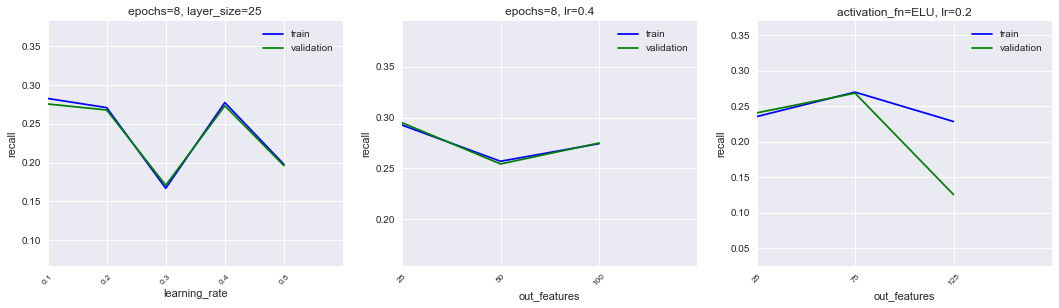

In [117]:
nn_val_curvs_fig, axs = plt.subplots(1, 3, figsize=(18, 4.5))
_, ax = nn_val_curv_relu_lr_plot.plot(ax=axs[0], title="epochs=8, layer_size=25")
_, ax = nn_val_curv_relu_plot.plot(ax=axs[1], title="epochs=8, lr=0.4")
_, ax = nn_val_curv_elu_plot.plot(ax=axs[2], title="activation_fn=ELU, lr=0.2")

In [118]:
nn_val_curvs_fig.savefig(
    "../out/BankData/NeuralNetwork/Validation Curves - Report.png",  
    bbox_inches='tight',
    dpi=800
)

In [120]:
nn_tuned_model_eval = ModelEvaluation(nn_tuned_clf)
nn_tuned_model_eval.run(bank_data.X_train, bank_data.y_train, bank_data.X_test, bank_data.y_test)
print(nn_tuned_model_eval.model)
print(ClassificationReport(experiment=nn_tuned_model_eval).plot())

Epoch:  0  -  0.8398728870576427
Epoch:  1  -  0.3859791063493298
Epoch:  2  -  0.31844324065792945
Epoch:  3  -  0.28956567568163716
Epoch:  4  -  0.27810540122370564
Epoch:  5  -  0.27156012865804857
Epoch:  6  -  0.26775896453088327
Epoch:  7  -  0.2647788553468643
Epoch:  8  -  0.2628903811977756
Epoch:  9  -  0.26121454950301876
Epoch:  10  -  0.26002890256143385
Epoch:  11  -  0.258731976632149
Epoch:  12  -  0.2578447807219721
Epoch:  13  -  0.2569267153739929
Epoch:  14  -  0.25632285398821675
Epoch:  15  -  0.2555529561734969
Epoch:  16  -  0.25499137755363216
Epoch:  17  -  0.2543026237718521
Epoch:  18  -  0.2539648269453356
Epoch:  19  -  0.25340516432639093
NeuralNetworkClassifier(in_features=26, learning_rate=0.4, out_features=26,
                        verbose=True)
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     11966
           1       0.63      0.12      0.21      1598

    accuracy                           0.89

## Compare Wall Clock Times

In [121]:
compare_fit_scores_times_plot = CompareFitScoreTimes(experiments=[
    dt_tuned_learning_curve, 
    svm_tuned_learning_curve, 
    knn_tuned_learning_curve,
    ada_tuned_learning_curve,
    nn_tuned_learning_curve
])

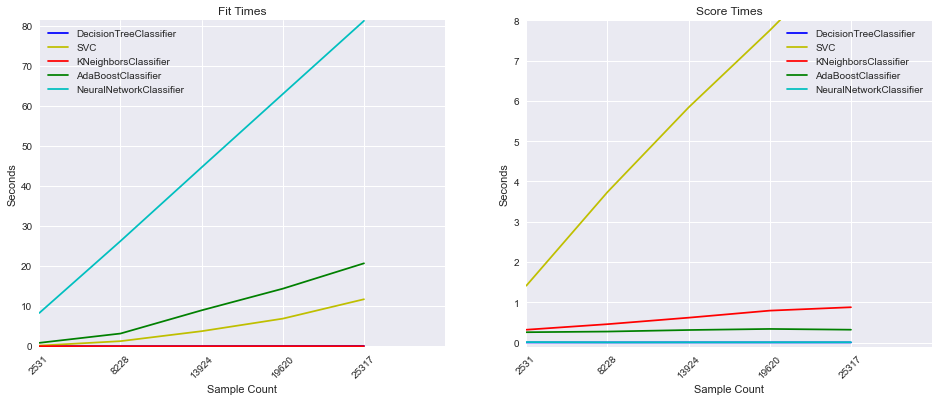

In [122]:
compare_fit_scores_times_fig, ax = compare_fit_scores_times_plot.plot(figsize=(16, 6), ymin=0.0, ymax=8.0)

In [124]:
compare_fit_scores_times_fig.savefig(
    "../out/BankData/Compare Fit and Times - Report.png",  
    bbox_inches='tight',
    dpi=800
)